## Baseline Model

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

#define  basis functions
def make_basis(x):
    # the components are 1,x, cos(2 \pi x), sin(2 \pi x)...
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    return np.hstack([np.ones((x.shape[0],1)),x, periodic ]) 

#  periodic basis starts at column:
col_per = 2

#baseline model
def run_model(x,y,plot=False):    
    H = make_basis(x.reshape(-1,1))
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    H_np = H[:,0:col_per]

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    all_prediction = np.dot(H,posterior['weights'].T).T
    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T
    if plot==True:
        plt.figure()
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)
    Gradients = []
    for i in range(non_periodic_prediction.shape[0]):
        Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))
        
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print("probability that the function is increasing=", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        return 1
    else:
        return 0

    
#this is the inpu
x = np.linspace(0,1,100)    

We test the model in a toy example. If we remove the seasonality component, then the following time-series is increasing.

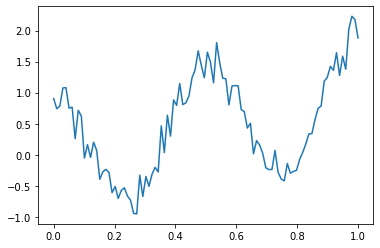

In [2]:

y =  x + np.cos(4*np.pi*x) + np.random.randn(len(x))*0.2
plt.plot(x,y)

Average Loss = 100.64: 100%|██████████| 60000/60000 [00:15<00:00, 3917.02it/s]
Finished [100%]: Average Loss = 100.63


probability that the function is increasing= 1.0


1

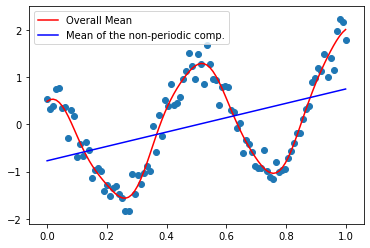

In [3]:
run_model(x,y,plot=True)

It works well in this case :)

In the following example, the  time-series is not increasing and it does not have any seasonality component.

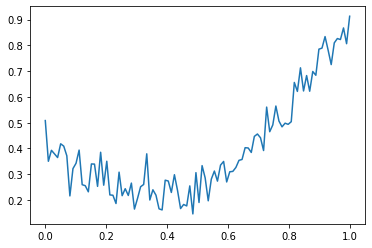

In [4]:
#toy example
y =  x/2-2*np.exp(-(x-0.5)**2) + 2 + np.random.randn(len(x))*0.05
plt.plot(x,y)

Average Loss = 109.64: 100%|██████████| 60000/60000 [00:15<00:00, 3952.08it/s]
Finished [100%]: Average Loss = 109.64


probability that the function is increasing= 1.0


1

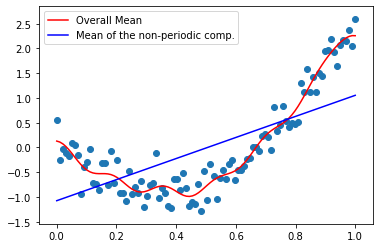

In [5]:
run_model(x,y, plot=True)

It doesn't work well, the correct answer should be not-increasing. The problem is that the cos/sin base can also fit any non-linear function in [0,1] :(.

## We run it on the test set

In [6]:
x = np.linspace(0,1,100)
test_df = pd.read_csv("./data/test.csv")


Decision = pd.DataFrame(columns=['Id','Category'])
for r in range(test_df.shape[0]):
    id_row = test_df.iloc[r,0]
    y = test_df.iloc[r,1:].values
    decision = run_model(x,y)
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
    print(Decision)
    Decision.to_csv("Decision_baseline.csv",  index=False)

Average Loss = 127.89: 100%|██████████| 60000/60000 [00:15<00:00, 3905.95it/s]
Finished [100%]: Average Loss = 127.89


probability that the function is increasing= 1.0
  Id Category
0  0        1


Average Loss = 201.68: 100%|██████████| 60000/60000 [00:15<00:00, 3915.01it/s]
Finished [100%]: Average Loss = 201.68


probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1


Average Loss = 211.99: 100%|██████████| 60000/60000 [00:15<00:00, 3857.46it/s]
Finished [100%]: Average Loss = 212


probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1
2  2        1


Average Loss = 216.7: 100%|██████████| 60000/60000 [00:16<00:00, 3742.14it/s] 
Finished [100%]: Average Loss = 216.7


probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1
2  2        1
3  3        1


Average Loss = 116.58: 100%|██████████| 60000/60000 [00:15<00:00, 3819.09it/s]
Finished [100%]: Average Loss = 116.57


probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1
2  2        1
3  3        1
4  4        1


Average Loss = 102.68:  80%|███████▉  | 47714/60000 [00:11<00:02, 5319.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 102.14: 100%|██████████| 60000/60000 [00:13<00:00, 4304.20it/s]
Finished [100%]: Average Loss = 102.15


probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1
2  2        1
3  3        1
4  4        1
5  5        1


Average Loss = 174.42: 100%|██████████| 60000/60000 [00:12<00:00, 4688.44it/s]
Finished [100%]: Average Loss = 174.41


probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1
2  2        1
3  3        1
4  4        1
5  5        1
6  6        1


Average Loss = 219.27:  24%|██▍       | 14611/60000 [00:02<00:09, 4950.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 216.83: 100%|██████████| 60000/60000 [00:12<00:00, 4906.99it/s]
Finished [100%]: Average Loss = 216.84


probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1
2  2        1
3  3        1
4  4        1
5  5        1
6  6        1
7  7        1


Average Loss = 207.41:  31%|███▏      | 18866/60000 [00:03<00:07, 5363.51it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 206.58:  62%|██████▏   | 36971/60000 [00:07<00:04, 5289.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 206.5:  93%|█████████▎| 55521/60000 [00:10<00:00, 5367.43it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1
2  2        1
3  3        1
4  4        1
5  5        1
6  6        1
7  7        1
8  8        1


Average Loss = 147.43:  24%|██▍       | 14401/60000 [00:02<00:09, 4724.56it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 68.602:  56%|█████▌    | 33423/60000 [00:06<00:05, 5254.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 57.55:  86%|████████▋ | 51891/60000 [00:09<00:01, 5398.17it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1
2  2        1
3  3        1
4  4        1
5  5        1
6  6        1
7  7        1
8  8        1
9  9        1


Average Loss = 161.39:  24%|██▍       | 14585/60000 [00:02<00:11, 3831.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 126.76: 100%|██████████| 60000/60000 [00:21<00:00, 2787.77it/s]
Finished [100%]: Average Loss = 126.76


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1


Average Loss = 174.77: 100%|██████████| 60000/60000 [00:24<00:00, 2415.71it/s]
Finished [100%]: Average Loss = 174.78


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1


Average Loss = 109.56: 100%|██████████| 60000/60000 [00:24<00:00, 2449.27it/s]
Finished [100%]: Average Loss = 109.56


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1


Average Loss = 200.51: 100%|██████████| 60000/60000 [00:24<00:00, 2423.05it/s]
Finished [100%]: Average Loss = 200.51


probability that the function is increasing= 0.894
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0


Average Loss = 216.44: 100%|██████████| 60000/60000 [00:24<00:00, 2417.13it/s]
Finished [100%]: Average Loss = 216.44


probability that the function is increasing= 0.002
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0


Average Loss = 222.8: 100%|██████████| 60000/60000 [00:24<00:00, 2462.16it/s] 
Finished [100%]: Average Loss = 222.8


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1


Average Loss = 204.51: 100%|██████████| 60000/60000 [00:14<00:00, 4065.73it/s]
Finished [100%]: Average Loss = 204.52


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1


Average Loss = 190.84: 100%|██████████| 60000/60000 [00:15<00:00, 3935.49it/s]
Finished [100%]: Average Loss = 190.84


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1


Average Loss = 190.68: 100%|██████████| 60000/60000 [00:15<00:00, 3998.32it/s]
Finished [100%]: Average Loss = 190.68


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1


Average Loss = 174.51: 100%|██████████| 60000/60000 [00:14<00:00, 4040.57it/s]
Finished [100%]: Average Loss = 174.51


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1


Average Loss = 197.94: 100%|██████████| 60000/60000 [00:14<00:00, 4135.45it/s]
Finished [100%]: Average Loss = 197.95


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1


Average Loss = 212.2: 100%|██████████| 60000/60000 [00:15<00:00, 3947.62it/s] 
Finished [100%]: Average Loss = 212.19


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1


Average Loss = 214.12: 100%|██████████| 60000/60000 [00:12<00:00, 4637.90it/s]
Finished [100%]: Average Loss = 214.13


probability that the function is increasing= 0.052
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0


Average Loss = 201.93:  42%|████▏     | 25356/60000 [00:05<00:06, 5301.93it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 201.77:  76%|███████▌  | 45672/60000 [00:09<00:03, 4573.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 201.66: 100%|██████████| 60000/60000 [00:12<00:00, 4866.43it/s]
Finished [100%]: Average Loss = 201.67


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1


Average Loss = 198.51:  96%|█████████▋| 57763/60000 [00:12<00:00, 5053.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1


Average Loss = 224.51: 100%|██████████| 60000/60000 [00:15<00:00, 3863.94it/s]
Finished [100%]: Average Loss = 224.51


probability that the function is increasing= 0.156
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0


Average Loss = 198.43: 100%|██████████| 60000/60000 [00:14<00:00, 4057.08it/s]
Finished [100%]: Average Loss = 198.42


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1


Average Loss = 220.52: 100%|██████████| 60000/60000 [00:14<00:00, 4074.49it/s]
Finished [100%]: Average Loss = 220.52


probability that the function is increasing= 0.09
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0


Average Loss = 105.98: 100%|██████████| 60000/60000 [00:15<00:00, 3980.04it/s]
Finished [100%]: Average Loss = 105.99


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1


Average Loss = 136.95: 100%|██████████| 60000/60000 [00:15<00:00, 3957.03it/s]
Finished [100%]: Average Loss = 136.95


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1


Average Loss = 124.89: 100%|██████████| 60000/60000 [00:15<00:00, 3944.57it/s]
Finished [100%]: Average Loss = 124.89


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1


Average Loss = 170.89: 100%|██████████| 60000/60000 [00:15<00:00, 3958.70it/s]
Finished [100%]: Average Loss = 170.89


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1


Average Loss = 128.69: 100%|██████████| 60000/60000 [00:15<00:00, 3964.30it/s]
Finished [100%]: Average Loss = 128.69


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1


Average Loss = 132.42: 100%|██████████| 60000/60000 [00:15<00:00, 3829.02it/s]
Finished [100%]: Average Loss = 132.42


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1


Average Loss = 192.23:  24%|██▍       | 14531/60000 [00:02<00:08, 5517.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 178.42:  56%|█████▋    | 33861/60000 [00:06<00:05, 4781.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 175.42:  87%|████████▋ | 52226/60000 [00:09<00:01, 4438.27it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1


Average Loss = 166.97:  25%|██▍       | 14744/60000 [00:02<00:08, 5445.20it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 139.63:  57%|█████▋    | 34391/60000 [00:06<00:04, 5415.71it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 136.02:  89%|████████▊ | 53107/60000 [00:09<00:01, 5256.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1


Average Loss = 125.05:  89%|████████▉ | 53411/60000 [00:11<00:01, 5409.68it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 124.75: 100%|██████████| 60000/60000 [00:12<00:00, 4726.26it/s]
Finished [100%]: Average Loss = 124.74


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1


Average Loss = 222.91:  27%|██▋       | 16266/60000 [00:03<00:08, 5039.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 221.6:  58%|█████▊    | 34671/60000 [00:06<00:05, 4921.20it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 221.57: 100%|██████████| 60000/60000 [00:12<00:00, 4907.91it/s]
Finished [100%]: Average Loss = 221.57


probability that the function is increasing= 0.004
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0


Average Loss = 109.47: 100%|██████████| 60000/60000 [00:13<00:00, 4506.08it/s]
Finished [100%]: Average Loss = 109.48


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1


Average Loss = 219.51:  38%|███▊      | 22681/60000 [00:05<00:08, 4427.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 219.08: 100%|██████████| 60000/60000 [00:12<00:00, 4709.00it/s]
Finished [100%]: Average Loss = 219.08


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1


Average Loss = 161.15:  24%|██▍       | 14680/60000 [00:02<00:08, 5449.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 127.81:  57%|█████▋    | 34258/60000 [00:06<00:04, 5457.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 123.88:  89%|████████▉ | 53603/60000 [00:09<00:01, 5424.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1


Average Loss = 218.63: 100%|██████████| 60000/60000 [00:14<00:00, 4074.97it/s]
Finished [100%]: Average Loss = 218.64


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1


Average Loss = 205.18: 100%|██████████| 60000/60000 [00:14<00:00, 4085.18it/s]
Finished [100%]: Average Loss = 205.18


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1


Average Loss = 220.23: 100%|██████████| 60000/60000 [00:14<00:00, 4113.60it/s]
Finished [100%]: Average Loss = 220.22


probability that the function is increasing= 0.012
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0


Average Loss = 124.74: 100%|██████████| 60000/60000 [00:14<00:00, 4194.82it/s]
Finished [100%]: Average Loss = 124.75


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1


Average Loss = 115.68: 100%|██████████| 60000/60000 [00:13<00:00, 4312.23it/s]
Finished [100%]: Average Loss = 115.67


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1


Average Loss = 203.81:  24%|██▍       | 14511/60000 [00:02<00:09, 5017.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 198.96: 100%|██████████| 60000/60000 [00:12<00:00, 4774.98it/s]
Finished [100%]: Average Loss = 198.96


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1


Average Loss = 110.33:  78%|███████▊  | 47030/60000 [00:09<00:02, 5131.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 108.47: 100%|██████████| 60000/60000 [00:12<00:00, 4831.33it/s]
Finished [100%]: Average Loss = 108.46


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1


Average Loss = 211.14:  74%|███████▎  | 44184/60000 [00:09<00:03, 4823.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 210.78: 100%|██████████| 60000/60000 [00:13<00:00, 4523.02it/s]
Finished [100%]: Average Loss = 210.79


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1


Average Loss = 176.41: 100%|██████████| 60000/60000 [00:15<00:00, 3957.40it/s]
Finished [100%]: Average Loss = 176.41


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1


Average Loss = 57.212: 100%|██████████| 60000/60000 [00:14<00:00, 4115.46it/s]
Finished [100%]: Average Loss = 57.217


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1


Average Loss = 132.16: 100%|██████████| 60000/60000 [00:14<00:00, 4134.14it/s]
Finished [100%]: Average Loss = 132.17


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1


Average Loss = 200.86: 100%|██████████| 60000/60000 [00:14<00:00, 3908.08it/s]
Finished [100%]: Average Loss = 200.87


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1


Average Loss = 222.83: 100%|██████████| 60000/60000 [00:14<00:00, 4019.93it/s]
Finished [100%]: Average Loss = 222.83


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1


Average Loss = 66.88: 100%|██████████| 60000/60000 [00:14<00:00, 4078.33it/s] 
Finished [100%]: Average Loss = 66.878


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1


Average Loss = 185.07: 100%|██████████| 60000/60000 [00:15<00:00, 3978.31it/s]
Finished [100%]: Average Loss = 185.05


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1


Average Loss = 197.47: 100%|██████████| 60000/60000 [00:14<00:00, 4147.59it/s]
Finished [100%]: Average Loss = 197.47


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1


Average Loss = 165.47: 100%|██████████| 60000/60000 [00:14<00:00, 4128.14it/s]
Finished [100%]: Average Loss = 165.48


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1


Average Loss = 121.45: 100%|██████████| 60000/60000 [00:14<00:00, 4167.46it/s]
Finished [100%]: Average Loss = 121.45


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58 

Average Loss = 115.33: 100%|██████████| 60000/60000 [00:14<00:00, 4047.36it/s]
Finished [100%]: Average Loss = 115.34


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
30  30        1
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58 

Average Loss = 177.54: 100%|██████████| 60000/60000 [00:14<00:00, 4104.79it/s]
Finished [100%]: Average Loss = 177.54


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
31  31        1
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58 

Average Loss = 62.986: 100%|██████████| 60000/60000 [00:14<00:00, 4108.20it/s]
Finished [100%]: Average Loss = 62.99


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
32  32        1
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59 

Average Loss = 164.85: 100%|██████████| 60000/60000 [00:14<00:00, 4146.52it/s]
Finished [100%]: Average Loss = 164.85


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
33  33        1
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60 

Average Loss = 221.65: 100%|██████████| 60000/60000 [00:15<00:00, 3888.43it/s]
Finished [100%]: Average Loss = 221.64


probability that the function is increasing= 0.302
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
34  34        1
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  6

Average Loss = 220.43: 100%|██████████| 60000/60000 [00:15<00:00, 3833.73it/s]
Finished [100%]: Average Loss = 220.42


probability that the function is increasing= 0.998
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
35  35        1
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  6

Average Loss = 56.553: 100%|██████████| 60000/60000 [00:15<00:00, 3996.88it/s]
Finished [100%]: Average Loss = 56.541


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
36  36        1
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63 

Average Loss = 166.24: 100%|██████████| 60000/60000 [00:14<00:00, 4111.38it/s]
Finished [100%]: Average Loss = 166.24


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
37  37        0
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64 

Average Loss = 173.48: 100%|██████████| 60000/60000 [00:14<00:00, 4061.40it/s]
Finished [100%]: Average Loss = 173.48


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
38  38        1
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65 

Average Loss = 208.77: 100%|██████████| 60000/60000 [00:14<00:00, 4045.91it/s]
Finished [100%]: Average Loss = 208.77


probability that the function is increasing= 0.042
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
39  39        1
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  6

Average Loss = 113.71: 100%|██████████| 60000/60000 [00:14<00:00, 4107.29it/s]
Finished [100%]: Average Loss = 113.71


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
40  40        1
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67 

Average Loss = 117.48: 100%|██████████| 60000/60000 [00:14<00:00, 4109.63it/s]
Finished [100%]: Average Loss = 117.48


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
41  41        1
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68 

Average Loss = 218.83: 100%|██████████| 60000/60000 [00:14<00:00, 4118.08it/s]
Finished [100%]: Average Loss = 218.84


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
42  42        1
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69 

Average Loss = 225.14: 100%|██████████| 60000/60000 [00:14<00:00, 4089.74it/s]
Finished [100%]: Average Loss = 225.14


probability that the function is increasing= 0.208
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
43  43        0
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  7

Average Loss = 170.03: 100%|██████████| 60000/60000 [00:14<00:00, 4078.68it/s]
Finished [100%]: Average Loss = 170.02


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
44  44        1
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71 

Average Loss = 162.11: 100%|██████████| 60000/60000 [00:14<00:00, 4085.77it/s]
Finished [100%]: Average Loss = 162.13


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
45  45        1
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72 

Average Loss = 118.11: 100%|██████████| 60000/60000 [00:14<00:00, 4073.02it/s]
Finished [100%]: Average Loss = 118.1


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
46  46        1
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73 

Average Loss = 118.6: 100%|██████████| 60000/60000 [00:14<00:00, 4121.08it/s] 
Finished [100%]: Average Loss = 118.61


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
47  47        1
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74 

Average Loss = 198.53: 100%|██████████| 60000/60000 [00:14<00:00, 4075.39it/s]
Finished [100%]: Average Loss = 198.54


probability that the function is increasing= 0.922
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
48  48        1
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  7

Average Loss = 162.96: 100%|██████████| 60000/60000 [00:14<00:00, 4075.44it/s]
Finished [100%]: Average Loss = 162.97


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
49  49        1
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76 

Average Loss = 158.05: 100%|██████████| 60000/60000 [00:14<00:00, 4101.72it/s]
Finished [100%]: Average Loss = 158.06


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
50  50        1
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77 

Average Loss = 117.29: 100%|██████████| 60000/60000 [00:14<00:00, 4103.12it/s]
Finished [100%]: Average Loss = 117.29


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
51  51        1
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78 

Average Loss = 121.79: 100%|██████████| 60000/60000 [00:14<00:00, 4089.77it/s]
Finished [100%]: Average Loss = 121.79


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
52  52        1
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79 

Average Loss = 128.91: 100%|██████████| 60000/60000 [00:14<00:00, 4057.39it/s]
Finished [100%]: Average Loss = 128.92


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
53  53        1
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80 

Average Loss = 69.016: 100%|██████████| 60000/60000 [00:14<00:00, 4046.36it/s]
Finished [100%]: Average Loss = 69.01


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
54  54        1
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81 

Average Loss = 198.79:  44%|████▍     | 26326/60000 [00:05<00:06, 5315.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 198.71:  75%|███████▌  | 45100/60000 [00:09<00:02, 5311.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 198.69: 100%|██████████| 60000/60000 [00:12<00:00, 4949.00it/s]
Finished [100%]: Average Loss = 198.68


probability that the function is increasing= 0.996
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
55  55        1
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  8

Average Loss = 214.66:  24%|██▍       | 14671/60000 [00:02<00:08, 5166.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 212.08:  55%|█████▍    | 32736/60000 [00:06<00:05, 5121.76it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 212.04:  86%|████████▋ | 51891/60000 [00:10<00:01, 5165.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 0.264
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
56  56        1
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  8

Average Loss = 223.26:  24%|██▍       | 14692/60000 [00:02<00:08, 5356.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 220.67:  55%|█████▌    | 33151/60000 [00:06<00:05, 5219.46it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 220.5:  86%|████████▌ | 51571/60000 [00:10<00:01, 5070.22it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
57  57        1
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84 

Average Loss = 214.11:  24%|██▍       | 14621/60000 [00:02<00:08, 5435.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 211.51:  56%|█████▌    | 33685/60000 [00:06<00:05, 5165.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 211.46:  86%|████████▋ | 51810/60000 [00:10<00:01, 5376.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
58  58        1
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85 

Average Loss = 164.61:  24%|██▍       | 14611/60000 [00:02<00:08, 5484.20it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 135.47:  57%|█████▋    | 34191/60000 [00:06<00:04, 5345.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 131.44:  88%|████████▊ | 52891/60000 [00:10<00:01, 5378.08it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
59  59        1
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86 

Average Loss = 148.08:  24%|██▍       | 14521/60000 [00:02<00:10, 4236.44it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 79.755:  56%|█████▌    | 33325/60000 [00:06<00:06, 4310.77it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 71.55:  88%|████████▊ | 52637/60000 [00:10<00:01, 4252.84it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
60  60        1
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86        1
87  87 

Average Loss = 225.02:  25%|██▍       | 14795/60000 [00:02<00:08, 5071.07it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 223.04:  55%|█████▍    | 32922/60000 [00:06<00:05, 4562.55it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 222.96:  86%|████████▌ | 51632/60000 [00:09<00:01, 4495.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 0.346
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
61  61        1
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86        1
87  87        1
88  8

Average Loss = 184.62:  24%|██▍       | 14361/60000 [00:02<00:08, 5209.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 169.98:  55%|█████▌    | 33206/60000 [00:06<00:06, 4319.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 167.37:  87%|████████▋ | 52412/60000 [00:10<00:01, 4278.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
62  62        1
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86        1
87  87        1
88  88        1
89  89 

Average Loss = 183.84:  24%|██▍       | 14324/60000 [00:02<00:08, 5109.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 173.11:  56%|█████▌    | 33471/60000 [00:06<00:05, 4901.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 171.94:  87%|████████▋ | 52151/60000 [00:10<00:01, 5266.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
63  63        0
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86        1
87  87        1
88  88        1
89  89        1
90  90 

Average Loss = 171.28:  24%|██▍       | 14596/60000 [00:02<00:08, 5294.44it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 151.51:  56%|█████▋    | 33866/60000 [00:06<00:05, 5064.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 149.55:  88%|████████▊ | 52843/60000 [00:10<00:01, 4259.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
64  64        1
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86        1
87  87        1
88  88        1
89  89        1
90  90        0
91  91 

Average Loss = 218.97:  25%|██▍       | 14813/60000 [00:02<00:08, 5040.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 216.69:  55%|█████▍    | 32991/60000 [00:06<00:05, 5172.02it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 216.71:  87%|████████▋ | 51917/60000 [00:09<00:01, 5256.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 0.098
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
65  65        1
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86        1
87  87        1
88  88        1
89  89        1
90  90        0
91  91        1
92  9

Average Loss = 207.2:  25%|██▍       | 14848/60000 [00:02<00:08, 5101.38it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 203.57:  55%|█████▍    | 32971/60000 [00:06<00:05, 5365.51it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 203.51:  87%|████████▋ | 52211/60000 [00:10<00:01, 5396.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoi

probability that the function is increasing= 0.102
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
66  66        1
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86        1
87  87        1
88  88        1
89  89        1
90  90        0
91  91        1
92  92        1
93  9

Average Loss = 184.78:  25%|██▍       | 14814/60000 [00:02<00:10, 4472.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 154.38: 100%|██████████| 60000/60000 [00:13<00:00, 4304.21it/s]
Finished [100%]: Average Loss = 154.38


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
67  67        1
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86        1
87  87        1
88  88        1
89  89        1
90  90        0
91  91        1
92  92        1
93  93        1
94  94 

Average Loss = 216.6: 100%|██████████| 60000/60000 [00:15<00:00, 3997.19it/s] 
Finished [100%]: Average Loss = 216.6


probability that the function is increasing= 0.84
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
68  68        0
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86        1
87  87        1
88  88        1
89  89        1
90  90        0
91  91        1
92  92        1
93  93        1
94  94        0
95  95

Average Loss = 207.88: 100%|██████████| 60000/60000 [00:14<00:00, 4035.55it/s]
Finished [100%]: Average Loss = 207.88


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
69  69        1
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86        1
87  87        1
88  88        1
89  89        1
90  90        0
91  91        1
92  92        1
93  93        1
94  94        0
95  95        0
96  96 

Average Loss = 215.85: 100%|██████████| 60000/60000 [00:14<00:00, 4023.39it/s]
Finished [100%]: Average Loss = 215.85


probability that the function is increasing= 1.0
    Id Category
0    0        1
1    1        1
2    2        1
3    3        1
4    4        1
5    5        1
6    6        1
7    7        1
8    8        1
9    9        1
10  10        1
11  11        1
12  12        1
13  13        0
14  14        0
15  15        1
16  16        1
17  17        1
18  18        1
19  19        1
20  20        1
21  21        1
22  22        0
23  23        1
24  24        1
25  25        0
26  26        1
27  27        0
28  28        1
29  29        1
..  ..      ...
70  70        1
71  71        1
72  72        0
73  73        1
74  74        1
75  75        1
76  76        1
77  77        0
78  78        1
79  79        1
80  80        1
81  81        1
82  82        1
83  83        1
84  84        1
85  85        0
86  86        1
87  87        1
88  88        1
89  89        1
90  90        0
91  91        1
92  92        1
93  93        1
94  94        0
95  95        0
96  96        1
97  97 

Average Loss = 116.6: 100%|██████████| 60000/60000 [00:14<00:00, 4029.38it/s] 
Finished [100%]: Average Loss = 116.6


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
71    71        1
72    72        0
73    73        1
74    74        1
75    75        1
76    76        1
77    77        0
78    78        1
79    79        1
80    80        1
81    81        1
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91       

Average Loss = 202.54: 100%|██████████| 60000/60000 [00:16<00:00, 3714.73it/s]
Finished [100%]: Average Loss = 202.54


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
72    72        0
73    73        1
74    74        1
75    75        1
76    76        1
77    77        0
78    78        1
79    79        1
80    80        1
81    81        1
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92       

Average Loss = 73.479: 100%|██████████| 60000/60000 [00:14<00:00, 4227.86it/s]
Finished [100%]: Average Loss = 73.483


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
73    73        1
74    74        1
75    75        1
76    76        1
77    77        0
78    78        1
79    79        1
80    80        1
81    81        1
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93       

Average Loss = 212.47:  69%|██████▉   | 41448/60000 [00:08<00:03, 5066.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 212.33: 100%|██████████| 60000/60000 [00:12<00:00, 4905.91it/s]
Finished [100%]: Average Loss = 212.33


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
74    74        1
75    75        1
76    76        1
77    77        0
78    78        1
79    79        1
80    80        1
81    81        1
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94       

Average Loss = 175.14:  63%|██████▎   | 38050/60000 [00:08<00:04, 4926.35it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 173.75: 100%|██████████| 60000/60000 [00:12<00:00, 4825.11it/s]
Finished [100%]: Average Loss = 173.76


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
75    75        1
76    76        1
77    77        0
78    78        1
79    79        1
80    80        1
81    81        1
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95       

Average Loss = 213.85: 100%|██████████| 60000/60000 [00:12<00:00, 4727.89it/s]
Finished [100%]: Average Loss = 213.84


probability that the function is increasing= 0.046
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
76    76        1
77    77        0
78    78        1
79    79        1
80    80        1
81    81        1
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96     

Average Loss = 149.7:  24%|██▍       | 14394/60000 [00:02<00:08, 5112.63it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 51.335: 100%|██████████| 60000/60000 [00:12<00:00, 4909.54it/s]
Finished [100%]: Average Loss = 51.349


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
77    77        0
78    78        1
79    79        1
80    80        1
81    81        1
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97       

Average Loss = 137.47:  58%|█████▊    | 34741/60000 [00:07<00:05, 4837.23it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 133.33: 100%|██████████| 60000/60000 [00:12<00:00, 4770.10it/s]
Finished [100%]: Average Loss = 133.33


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
78    78        1
79    79        1
80    80        1
81    81        1
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98       

Average Loss = 219.41:  97%|█████████▋| 58409/60000 [00:12<00:00, 5146.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



probability that the function is increasing= 0.984
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
79    79        1
80    80        1
81    81        1
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99     

Average Loss = 121.34:  40%|███▉      | 23981/60000 [00:04<00:07, 4708.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 106.59:  97%|█████████▋| 58420/60000 [00:12<00:00, 4712.99it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
80    80        1
81    81        1
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99        1
100  100       

Average Loss = 116.99: 100%|██████████| 60000/60000 [00:12<00:00, 4691.22it/s]
Finished [100%]: Average Loss = 117


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
81    81        1
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99        1
100  100        1
101  101       

Average Loss = 165.66:  24%|██▍       | 14332/60000 [00:02<00:10, 4529.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 131.15: 100%|██████████| 60000/60000 [00:12<00:00, 4819.77it/s]
Finished [100%]: Average Loss = 131.14


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
82    82        1
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99        1
100  100        1
101  101        1
102  102       

Average Loss = 82.011:  47%|████▋     | 28101/60000 [00:05<00:06, 4993.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 58.154: 100%|██████████| 60000/60000 [00:12<00:00, 4893.94it/s]
Finished [100%]: Average Loss = 58.151


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
83    83        1
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99        1
100  100        1
101  101        1
102  102        1
103  103       

Average Loss = 153.17:  27%|██▋       | 16211/60000 [00:03<00:08, 5220.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 128.29:  59%|█████▉    | 35603/60000 [00:07<00:04, 5066.55it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 125.23: 100%|██████████| 60000/60000 [00:12<00:00, 4829.23it/s]
Finished [100%]: Average Loss = 125.22


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
84    84        1
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99        1
100  100        1
101  101        1
102  102        1
103  103        1
104  104       

Average Loss = 118.7:  97%|█████████▋| 57915/60000 [00:12<00:00, 4951.78it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
85    85        0
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99        1
100  100        1
101  101        1
102  102        1
103  103        1
104  104        1
105  105       

Average Loss = 221.7:  44%|████▍     | 26442/60000 [00:05<00:06, 5009.07it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 221.01:  76%|███████▋  | 45791/60000 [00:09<00:02, 5070.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 220.78: 100%|██████████| 60000/60000 [00:12<00:00, 4921.89it/s]
Finished [100%]: Average Loss = 220.78


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
86    86        1
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99        1
100  100        1
101  101        1
102  102        1
103  103        1
104  104        1
105  105        0
106  106       

Average Loss = 106.96: 100%|██████████| 60000/60000 [00:12<00:00, 4707.00it/s]
Finished [100%]: Average Loss = 106.96


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
87    87        1
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99        1
100  100        1
101  101        1
102  102        1
103  103        1
104  104        1
105  105        0
106  106        1
107  107       

Average Loss = 125.68: 100%|██████████| 60000/60000 [00:13<00:00, 4578.53it/s]
Finished [100%]: Average Loss = 125.68


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
88    88        1
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99        1
100  100        1
101  101        1
102  102        1
103  103        1
104  104        1
105  105        0
106  106        1
107  107        1
108  108       

Average Loss = 174.69: 100%|██████████| 60000/60000 [00:12<00:00, 4690.94it/s]
Finished [100%]: Average Loss = 174.69


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
89    89        1
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99        1
100  100        1
101  101        1
102  102        1
103  103        1
104  104        1
105  105        0
106  106        1
107  107        1
108  108        1
109  109       

Average Loss = 123.84: 100%|██████████| 60000/60000 [00:13<00:00, 4609.76it/s]
Finished [100%]: Average Loss = 123.84


probability that the function is increasing= 1.0
      Id Category
0      0        1
1      1        1
2      2        1
3      3        1
4      4        1
5      5        1
6      6        1
7      7        1
8      8        1
9      9        1
10    10        1
11    11        1
12    12        1
13    13        0
14    14        0
15    15        1
16    16        1
17    17        1
18    18        1
19    19        1
20    20        1
21    21        1
22    22        0
23    23        1
24    24        1
25    25        0
26    26        1
27    27        0
28    28        1
29    29        1
..   ...      ...
90    90        0
91    91        1
92    92        1
93    93        1
94    94        0
95    95        0
96    96        1
97    97        0
98    98        1
99    99        1
100  100        1
101  101        1
102  102        1
103  103        1
104  104        1
105  105        0
106  106        1
107  107        1
108  108        1
109  109        1
110  110       

## Ideas to improve baseline

1. Adding another non-linear basis function components (e.g., $tanh(w0+w1x)$) and seeing if you can better split the seasonal and non-seasonal component.
2. In the second example, the sin/cos basis function fits the nonlinear function, but it is clear that the obtained mean function is non-periodic. By definition a function is periodic in the interval [0,1] if you see at least one full cycle (e.g. $cos(\pi x)$ is not peridic in [0,1] but $cos(2 \pi x)$ is). So you could try to verify if the function is periodic or not. In case it is periodic you can use "non_periodic_prediction" for checking if the function is increasing or not. Instead, if the function is not periodic that you could use  "all_prediction" for checking if the function is increasing or not. How can you test if a function is periodic or not given your basis functions in H ?
3. The baseline model computes the derivative of the non-seasonal component and checks if the derivative is non-negative for all $x\in[0,1]$ as a way to assess if sales are increasing. Could an analytical derivative work better in the above case?
4. You could try to use GPs
5. Is the decision criterion "posterior_probability_deriviative_is_positive>0.95" the best way to make decisions? Maybe you would do better if you take into account the way weighted accuracy is defined for this competition.